In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
cwd = os.getcwd()

NOTEBOOK_DIR = os.path.dirname(cwd)
ROOT = os.path.dirname(os.path.dirname(os.path.dirname(NOTEBOOK_DIR)))

FIGURES_DIR = os.path.join(ROOT, 'figures/abc_parameterizations/debug_ipllr_renorm/bias')
CONFIG_PATH = os.path.join(ROOT, 'pytorch/configs/abc_parameterizations', 'fc_ipllr_mnist.yaml')

In [3]:
import sys
sys.path.append(ROOT)

In [4]:
import os
from copy import deepcopy
import torch
import math
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, Subset, DataLoader
import torch.nn.functional as F

from utils.tools import read_yaml, set_random_seeds
from pytorch.configs.base import BaseConfig
from pytorch.configs.model import ModelConfig
from pytorch.models.abc_params.fully_connected.ipllr_bias import FcIPLLRBias
from pytorch.models.abc_params.fully_connected.muP import FCmuP
from pytorch.models.abc_params.fully_connected.ntk import FCNTK
from pytorch.models.abc_params.fully_connected.standard_fc_ip import StandardFCIP
from utils.dataset.mnist import load_data
from utils.abc_params.debug_ipllr import *
from utils.plot.abc_parameterizations.debug_ipllr import *

### Load basic configuration and define variables 

In [5]:
N_TRIALS = 1
SEED = 30
L = 6
width = 1024
n_warmup_steps = 1
batch_size = 512
base_lr = 0.1
n_steps = 150
renorm_first = False
scale_first_lr = False
activation = 'elu'

set_random_seeds(SEED)  # set random seed for reproducibility
config_dict = read_yaml(CONFIG_PATH)

In [6]:
config_dict = read_yaml(CONFIG_PATH)

input_size = config_dict['architecture']['input_size']

config_dict['architecture']['width'] = width
config_dict['architecture']['n_layers'] = L + 1
config_dict['optimizer']['params']['lr'] = base_lr
config_dict['activation']['name'] = activation
config_dict['scheduler'] = {'name': 'warmup_switch',
                            'params': {'n_warmup_steps': n_warmup_steps,
                                       'calibrate_base_lr': False,
                                       'default_calibration': False}}
        
base_model_config = ModelConfig(config_dict)

### Load data & define models

In [7]:
training_dataset, test_dataset = load_data(download=False, flatten=True)
train_data_loader = DataLoader(training_dataset, shuffle=True, batch_size=batch_size)
test_batches = list(DataLoader(test_dataset, shuffle=False, batch_size=batch_size))
batches = list(train_data_loader)
eval_batch = test_batches[0]

In [8]:
# standard ipllr bias
config_dict['scheduler']['params']['calibrate_base_lr'] = False
config = ModelConfig(config_dict)
ipllrs_bias = [FcIPLLRBias(config) for _ in range(N_TRIALS)]

# ipllr bias with default calibration (i.e. base_lr = 1.0 for first step)
config_dict['scheduler']['params']['calibrate_base_lr'] = True
config_dict['scheduler']['params']['default_calibration'] = True
config = ModelConfig(config_dict)
ipllrs_bias_calib_default = [FcIPLLRBias(config) for _ in range(N_TRIALS)]

# ipllr bias with full calibration
config_dict['scheduler']['params']['calibrate_base_lr'] = True
config_dict['scheduler']['params']['default_calibration'] = False
config = ModelConfig(config_dict)
ipllrs_bias_calib = [FcIPLLRBias(config, lr_calibration_batches=batches) for _ in range(N_TRIALS)]

# ipllr bias with scaling bias lr
config_dict['scheduler']['params']['calibrate_base_lr'] = False
config = ModelConfig(config_dict)
ipllrs_bias_scale_bias_lr = [FcIPLLRBias(config) for _ in range(N_TRIALS)]

initial base lr : [78.5, 725.7666625976562, 200.583740234375, 142.47984313964844, 131.24835205078125, 88.80453491210938, 8.912617683410645]


In [9]:
for i in range(N_TRIALS):    
    ipllrs_bias_calib_default[i].copy_initial_params_from_model(ipllrs_bias[i])
    ipllrs_bias_scale_bias_lr[i].copy_initial_params_from_model(ipllrs_bias[i])
    ipllrs_bias_calib[i].copy_initial_params_from_model(ipllrs_bias[i])
    
    ipllrs_bias_calib_default[i].initialize_params()
    ipllrs_bias_scale_bias_lr[i].initialize_params()
    ipllrs_bias_calib[i].initialize_params()

In [10]:
# Make sure calibration takes into account normalization

#for ipllr in ipllrs_calib:    
#    initial_base_lrs = ipllr.scheduler.calibrate_base_lr(ipllr, batches=batches, normalize_first=False)
#    ipllr.scheduler._set_param_group_lrs(initial_base_lrs)
    
#for ipllr in ipllrs_calib_renorm:        
#    initial_base_lrs = ipllr.scheduler.calibrate_base_lr(ipllr, batches=batches, normalize_first=True)
#    ipllr.scheduler._set_param_group_lrs(initial_base_lrs)
    
#for ipllr in ipllrs_calib_renorm_scale_lr:            
#    initial_base_lrs = ipllr.scheduler.calibrate_base_lr(ipllr, batches=batches, normalize_first=True)
#    ipllr.scheduler._set_param_group_lrs(initial_base_lrs)

In [11]:
# scale lr of first layer if needed

#for ipllr in ipllrs_renorm_scale_lr:
#    for i, param_group in enumerate(ipllr.optimizer.param_groups):
#        if i == 0:
#            param_group['lr'] = param_group['lr'] * (ipllr.d + 1)
#    ipllr.scheduler.warm_lrs[0] = ipllr.scheduler.warm_lrs[0] * (ipllr.d + 1)
    
for i in range(N_TRIALS): 
    ipllrs_bias[i].scheduler.initial_lrs[0] = ipllrs_bias[i].scheduler.initial_lrs[0] * (ipllrs_bias[i].d + 1)
    ipllrs_bias_calib_default[i].scheduler.initial_lrs[0] = \
        ipllrs_bias_calib_default[i].scheduler.initial_lrs[0] * (ipllrs_bias[i].d + 1)
    ipllrs_bias_scale_bias_lr[i].scheduler.initial_lrs[0] = \
        ipllrs_bias_scale_bias_lr[i].scheduler.initial_lrs[0] * (ipllrs_bias[i].d + 1)
    
    ipllrs_bias[i].warm_lrs[0] = ipllrs_bias[i].scheduler.warm_lrs[0] * (ipllrs_bias[i].d + 1)
    ipllrs_bias_calib_default[i].scheduler.warm_lrs[0] = \
        ipllrs_bias_calib_default[i].scheduler.warm_lrs[0] * (ipllrs_bias[i].d + 1)
    ipllrs_bias_scale_bias_lr[i].scheduler.warm_lrs[0] = \
        ipllrs_bias_scale_bias_lr[i].scheduler.warm_lrs[0] * (ipllrs_bias[i].d + 1)
    
    ipllrs_bias_calib[i].warm_lrs[0] = ipllrs_bias[i].scheduler.warm_lrs[0] * (ipllrs_bias_calib[i].d + 1)
    ipllrs_bias_calib[i].scheduler.warm_lrs[0] = \
        ipllrs_bias_calib[i].scheduler.warm_lrs[0] * (ipllrs_bias_calib[i].d + 1)
    ipllrs_bias_calib[i].scheduler.warm_lrs[0] = \
        ipllrs_bias_calib[i].scheduler.warm_lrs[0] * (ipllrs_bias_calib[i].d + 1)

In [12]:
results = dict()

# without calibration
#results['ipllr'] = [collect_training_losses(ipllrs[i], batches, n_steps, normalize_first=False) 
#                    for i in range(N_TRIALS)]

#results['ipllr_renorm'] = [collect_training_losses(ipllrs_renorm[i], batches, n_steps, normalize_first=True)
#                           for i in range(N_TRIALS)]

#results['ipllr_renorm_scale_lr'] = [collect_training_losses(ipllrs_renorm_scale_lr[i], batches, n_steps, 
#                                                            normalize_first=True) 
#                                    for i in range(N_TRIALS)]

# with calibration
results['ipllr_bias'] = [collect_training_losses(ipllrs_bias[i], batches, n_steps, normalize_first=True)
                         for i in range(N_TRIALS)]

results['ipllr_bias_calib_default'] = [collect_training_losses(ipllrs_bias_calib_default[i], batches, n_steps, 
                                                               normalize_first=True)
                                       for i in range(N_TRIALS)]

results['ipllr_bias_calib'] = [collect_training_losses(ipllrs_bias_calib_default[i], batches, n_steps, 
                                                               normalize_first=True)
                                       for i in range(N_TRIALS)]

results['ipllrs_bias_scale_bias_lr'] = \
    [collect_training_losses(ipllrs_bias_scale_bias_lr[i], batches, n_steps, normalize_first=True) 
     for i in range(N_TRIALS)]

# Training

In [13]:
mode = 'training'

In [14]:
losses = dict()
for key, res in results.items():
    losses[key] = [r[0] for r in res]
    
chis = dict()
for key, res in results.items():
    chis[key] = [r[1] for r in res]

## Losses and derivatives

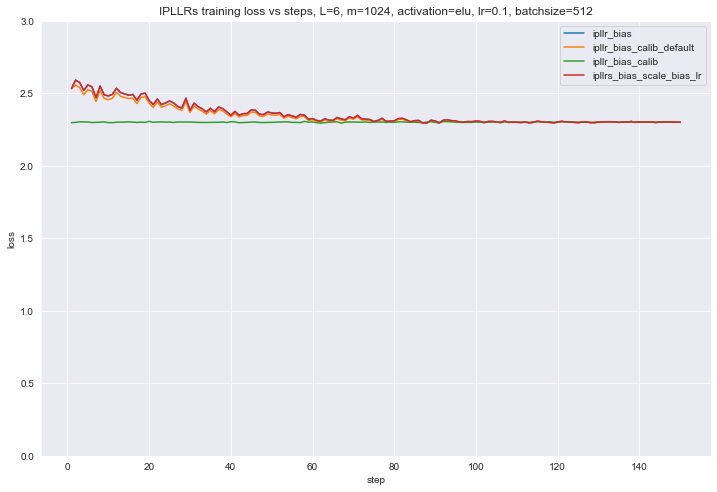

In [15]:
key = 'loss'
plt.figure(figsize=(12, 8))
plot_losses_models(losses, key=key, L=L, width=width, activation=activation, lr=base_lr, batch_size=batch_size, 
                   mode=mode, normalize_first=renorm_first, marker=None, name='IPLLR')
#plt.savefig(
#    os.path.join(FIGURES_DIR, 'IPLLRs_1_last_small_{}_{}_L={}_m={}_lr={}_bs={}.png'.\
#                 format(mode, key, L, width, base_lr, batch_size, renorm_first, scale_first_lr)))
plt.ylim(0,3)
plt.show()

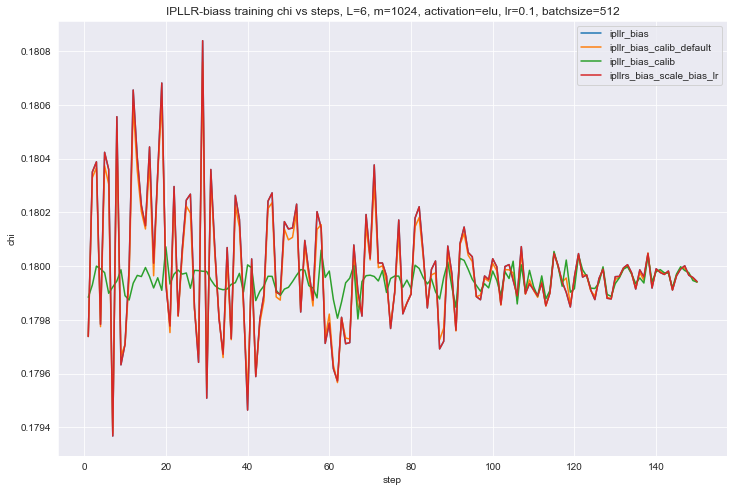

In [16]:
key = 'chi'
plt.figure(figsize=(12, 8))
plot_losses_models(chis, key=key, L=L, width=width, activation=activation, lr=base_lr, batch_size=batch_size, 
                   mode=mode, marker=None, name='IPLLR-bias')
#plt.savefig(os.path.join(FIGURES_DIR, 'IPLLRs_1_last_small_{}_{}_L={}_m={}_lr={}_bs={}.png'.\
#                         format(mode, key, L, width, base_lr, batch_size)))
plt.show()